In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import nltk
import matplotlib.pyplot as plt
import sklearn_crfsuite
import gensim
import sys
import warnings

from collections import Counter
from tqdm import tqdm_notebook
from sklearn.metrics import make_scorer
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
sys.path.append("study/5course/NLP-mipt/hw2/")

from src.learner import NerLearner, validate_step, predict

---
# Part 1 Analyze and prepare.

In [2]:
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('valid_tokens.csv', sep=',')

In [3]:
train.head()

,Unnamed: 0,tokens,tags
0,0,В Пакистане роходят акции исламистов против от...,O B_LOC O O O O O B_ORG I_ORG O B_PER
1,1,Как сообщает Пакистанская служба Радио Свобода...,O O B_ORG I_ORG I_ORG I_ORG O O B_LOC O O O O ...
2,2,В городе Карачи ющие жгли шины .,O O B_LOC O O O O
3,3,В провинции Пенджаб толкновения с полицией .,O O B_LOC O O O O
4,4,Пакистанские силы безопасности установили охра...,O O O O O O O O O


In [4]:
print('train len is: %d' % len(train))
print('test len is: %d' % len(test))

train len is: 3788
test len is: 2714


Удалим nan значения из данных

In [5]:
train = train[train['tokens'].notna()]
test = test[test['tokens'].notna()]

In [6]:
print('train len is: %d' % len(train))
print('test len is: %d' % len(test))

train len is: 3783
test len is: 2714


---
###### 1.1. Analyze distribution of labels and plot.
---

In [7]:
labels = ' '.join(list(train['tags'])).split(' ')
labels_unique = np.unique(labels)

In [8]:
print('amount of labels is %d' % len(labels))
print('amount of unique labels is %d' % len(labels_unique))
print('labels: ' + str(labels_unique))

amount of labels is 59029
amount of unique labels is 11
labels: ['B_EVT' 'B_LOC' 'B_ORG' 'B_PER' 'B_PRO' 'I_EVT' 'I_LOC' 'I_ORG' 'I_PER'
 'I_PRO' 'O']


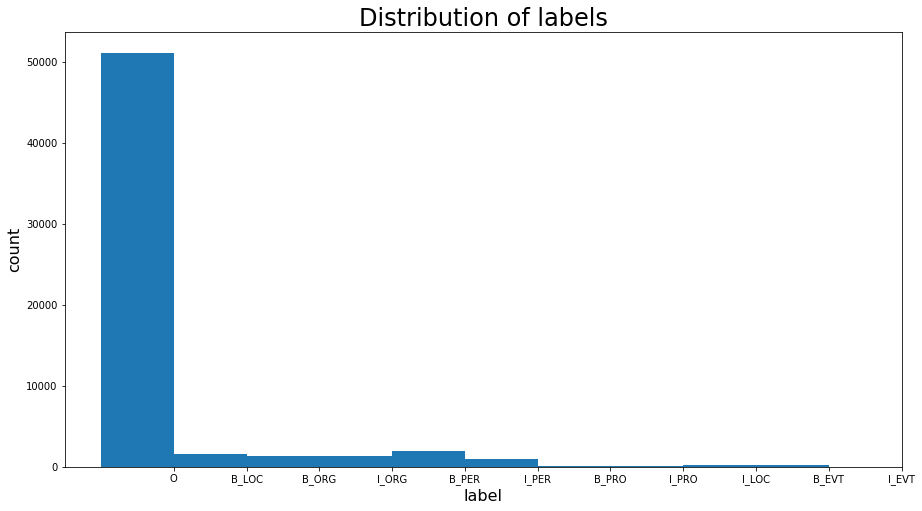

In [9]:
labels_dist = Counter(labels)

plt.figure(figsize=(15, 8))
plt.hist(labels, bins=np.arange(11) - 0.5)
plt.xticks(0.5 + np.arange(len(labels_dist.keys())), labels_dist.keys())
plt.title('Distribution of labels', fontsize=24)
plt.xlabel('label', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.show()

---
Как видим, большая часть лейблов не относится ни к одному из классов.

Посмотрим на распределение лейблов, относящихся к какому-то из классов.

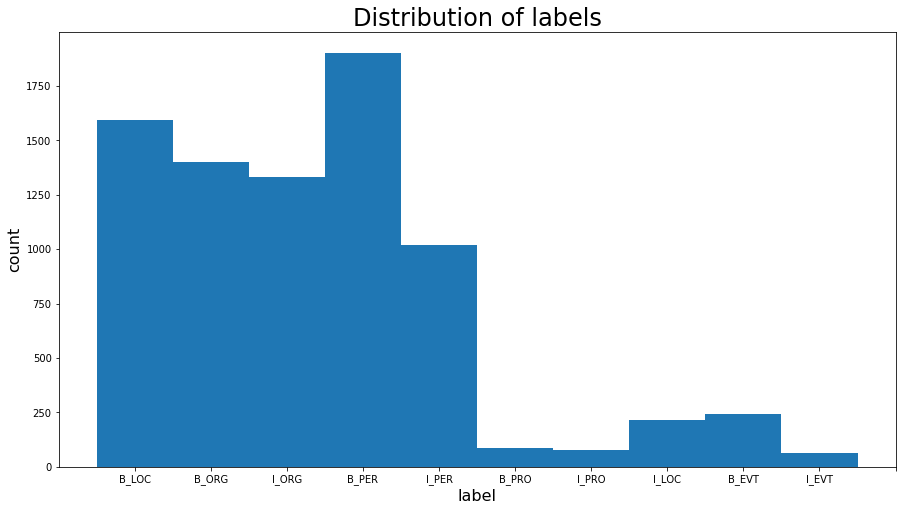

In [10]:
labels_wo_O = list(filter(lambda x: x != 'O', labels))

labels_dist = Counter(labels_wo_O)

plt.figure(figsize=(15, 8))
plt.hist(labels_wo_O, bins=np.arange(11) - 0.5)
plt.xticks(np.arange(len(labels_dist.keys()) + 1), labels_dist.keys())
plt.title('Distribution of labels', fontsize=24)
plt.xlabel('label', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.show()

---
###### 1.2. Remove unexcepted labels from data (if need) and describe how (if need).

В задаче нас просят классифицировать слова на 6 классов, в то время как в датасете встречаются 11 классов.

Удалим предложения, в которых встречаются неуместные лейблы (~250 предложений). Это самый простой подход, который уменьшит нам объём данных для обучения, но для начала сойдет. (можно еще заменить все unexpected labels на "O" и сравнить результаты).

Также удалим плохие предложения, после токенизации которых количество меток не совпадает с количеством токенов (~70 предложений).

In [11]:
labels_remain = set(['B_ORG', 'I_PER', 'I_LOC', 'I_ORG', 'B_LOC', 'B_PER', 'O'])
labels = list(train['tags'])

is_remained = [set(l.split(' ')).issubset(labels_remain) for l in labels]

percentage = 100. * (len(train) - sum(is_remained)) / len(train)
train = train[is_remained]

print('deleted sentences are %.2f percents of train set' % percentage)

deleted sentences are 8.41 percents of train set


---
# Part 2 Your own baseline.
###### 2.1 Make your own baseline with this tutorial https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html.

In [12]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [13]:
X_train = []
y_train = []
X_test = []

for i, row in tqdm_notebook(train.iterrows()):
    tokens = row[1].split(' ')
    pos = nltk.pos_tag(tokens)
    X_train.append(sent2features(pos))
    y_train.append(row[2].split(' '))
    
for i, row in tqdm_notebook(test.iterrows()):
    tokens = row[1].split(' ')
    pos = nltk.pos_tag(tokens)
    X_test.append(sent2features(pos))

In [13]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 5.79 s, sys: 51.1 ms, total: 5.84 s
Wall time: 5.88 s


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [14]:
y_pred = crf.predict(X_train)

metrics.flat_f1_score(y_train, y_pred,
                     average='macro', labels=list(crf.classes_))

0.9927993427213615

---
Все обучается, перейдём к кросс-валидации.

---
###### 2.2 Make crossvalidation.

In [258]:
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': sps.expon(scale=0.5),
    'c2': sps.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='macro')

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)

In [261]:
%%time
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 18.1min finished


CPU times: user 16min 29s, sys: 5 s, total: 16min 34s
Wall time: 18min 15s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None,...
                                 verbose=False),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f824d545550>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f824d50afd0>},
        

In [297]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.0036354063261784474, 'c2': 0.06156758465482312}
best CV score: 0.7289647227932926
model size: 1.75M


In [300]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=rs.best_params_['c1'],
    c2=rs.best_params_['c2'],
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.0036354063261784474, c2=0.06156758465482312,
    calibration_candidates=None, calibration_eta=None,
    calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [301]:
y_pred = crf.predict(X_test)

In [302]:
lbl_dict = {'B_ORG': 0, 'I_PER': 1, 'I_LOC': 2, 'I_ORG': 3, 'B_LOC': 4, 'B_PER': 5, 'O': 6}

submission_list = []

for row in y_pred:
    for lbl in row:
        submission_list.append(lbl_dict[lbl])

In [309]:
submission = pd.DataFrame({'Id': np.arange(len(submission_list)), 'Predicted': submission_list})

In [304]:
submission.to_csv('submission_baseline.csv', index=False)

---
Данный submission набрал 0.615 f1-score на тестовых данных на kaggle с гиперпараметрами $\text{c1}=0.0036$, $\text{c2}=0.061$.

Использовавшиеся фичи:

1. word.lower() - токен в нижнем регистре
2. word.isupper() - флаг, записан ли токен в верхнем регистре
3. word.istitle() - флаг, начинается ли токен с заглавной буквы
4. postag - тэг токена
5. postag[:2] - первые 2 символа тэга
6. фичи 1-5 для соселних токенов
7. word.isdigit() - флаг, является ли токен числом
8. word[-3:] - суффикс токена длины 3
9. word[-2:] - суффикс токена длины 2
10. BOS - флаг, является ли токен первым в предложении
11. EOS - флаг, является ли токен последним в предложении

Все эти фичи взяты из туториала https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html

---
# Part 3. Your favorite ml algorithm.

---
###### 3.1 Make submission to leaderboard and beat a baseline with your favorite ML algorithm (0.55 macro f1).

подход №1: rusVectores embedding + BiLSTM + CRF

---
разобъем данные на обучение и валидацию

In [49]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)
test_data = test.copy()

labels = []
for i, row in test_data.iterrows():
    labels.append(' '.join(['O'] * len(row[1].split(' '))))

test_data['labels'] = labels

train_data.columns = ['id', 'text', 'labels']
val_data.columns = ['id', 'text', 'labels']
test_data.columns = ['id', 'text', 'labels']

In [50]:
train_data.to_csv('train_data.csv', sep='\t')
val_data.to_csv('val_data.csv', sep='\t')
test_data.to_csv('test_data.csv', sep='\t')

---
загрузим модель эмбеддингов с rusVectores

In [51]:
model = gensim.models.KeyedVectors.load('model.model')

INFO:gensim.utils:loading Word2VecKeyedVectors object from model.model
INFO:gensim.utils:loading vectors from model.model.vectors.npy with mmap=None
INFO:gensim.utils:loading vectors_vocab from model.model.vectors_vocab.npy with mmap=None
INFO:gensim.utils:loading vectors_ngrams from model.model.vectors_ngrams.npy with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:setting ignored attribute vectors_vocab_norm to None
INFO:gensim.utils:setting ignored attribute vectors_ngrams_norm to None
INFO:gensim.utils:setting ignored attribute buckets_word to None
INFO:gensim.utils:loaded model.model


In [52]:
learn = NerLearner(
    train_df_path="~/study/5course/NLP-mipt/hw2/train_data.csv",
    valid_df_path="~/study/5course/NLP-mipt/hw2/val_data.csv",
    test_df_path="~/study/5course/NLP-mipt/hw2/test_data.csv",
    embedder=model,
    tensorboard_dir="logs",
    hidden_dim=1024,
    lr=0.0004,
    use_embeds=True
)

In [53]:
sum([p.numel() for p in learn.model.parameters() if p.requires_grad])

11434548

In [54]:
learn.model

BiLSTMCRF(
  (embeddings): Embedding(25238, 300)
  (lstm): BiLSTM(
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(300, 512, batch_first=True, bidirectional=True)
  )
  (crf): CRFDecoder(
    (input_dropout): Dropout(p=0.5, inplace=False)
    (linear): Linears(
      (linears): ModuleList(
        (0): Linear(in_features=1024, out_features=512, bias=True)
      )
      (output_linear): Linear(in_features=512, out_features=8, bias=True)
    )
    (crf): CRF()
  )
)

In [55]:
learn.fit(10)

INFO:root:Start training. Total epochs 10.
INFO:root:                                                                       
epoch 1, average train epoch loss=13.98

  0%|          | 0/174 [00:00<?, ?it/s]        

              precision    recall  f1-score   support

       B_LOC      0.791     0.318     0.454       346
       B_ORG      0.773     0.282     0.413       241
       B_PER      0.621     0.512     0.561       346
       I_LOC      0.000     0.000     0.000        29
       I_ORG      0.556     0.125     0.204       200
       I_PER      0.750     0.300     0.429       190
           O      0.920     0.989     0.953      9530

    accuracy                          0.906     10882
   macro avg      0.630     0.361     0.431     10882
weighted avg      0.891     0.906     0.887     10882



INFO:root:                                                                       
epoch 2, average train epoch loss=4.6424

  0%|          | 0/174 [00:00<?, ?it/s]        

              precision    recall  f1-score   support

       B_LOC      0.849     0.520     0.645       346
       B_ORG      0.729     0.469     0.571       241
       B_PER      0.735     0.688     0.710       346
       I_LOC      0.667     0.069     0.125        29
       I_ORG      0.583     0.350     0.438       200
       I_PER      0.760     0.600     0.671       190
           O      0.947     0.985     0.966      9530

    accuracy                          0.929     10882
   macro avg      0.753     0.526     0.589     10882
weighted avg      0.921     0.929     0.922     10882



INFO:root:                                                                       
epoch 3, average train epoch loss=2.2034

  0%|          | 0/174 [00:00<?, ?it/s]        

              precision    recall  f1-score   support

       B_LOC      0.901     0.555     0.687       346
       B_ORG      0.764     0.510     0.612       241
       B_PER      0.833     0.694     0.757       346
       I_LOC      0.714     0.172     0.278        29
       I_ORG      0.647     0.375     0.475       200
       I_PER      0.851     0.632     0.725       190
           O      0.948     0.991     0.969      9530

    accuracy                          0.937     10882
   macro avg      0.808     0.561     0.643     10882
weighted avg      0.931     0.937     0.930     10882



INFO:root:                                                                       
epoch 4, average train epoch loss=1.022

  0%|          | 0/174 [00:00<?, ?it/s]        

              precision    recall  f1-score   support

       B_LOC      0.892     0.595     0.714       346
       B_ORG      0.776     0.531     0.631       241
       B_PER      0.875     0.691     0.772       346
       I_LOC      0.500     0.138     0.216        29
       I_ORG      0.653     0.405     0.500       200
       I_PER      0.864     0.668     0.754       190
           O      0.950     0.990     0.969      9530

    accuracy                          0.939     10882
   macro avg      0.787     0.574     0.651     10882
weighted avg      0.934     0.939     0.933     10882



INFO:root:                                                                       
epoch 5, average train epoch loss=0.52951

  0%|          | 0/174 [00:00<?, ?it/s]        

              precision    recall  f1-score   support

       B_LOC      0.904     0.595     0.718       346
       B_ORG      0.766     0.531     0.627       241
       B_PER      0.894     0.685     0.776       346
       I_LOC      0.400     0.138     0.205        29
       I_ORG      0.667     0.390     0.492       200
       I_PER      0.838     0.653     0.734       190
           O      0.948     0.990     0.969      9530

    accuracy                          0.938     10882
   macro avg      0.774     0.569     0.646     10882
weighted avg      0.933     0.938     0.932     10882



INFO:root:                                                                        
epoch 6, average train epoch loss=0.33664

  0%|          | 0/174 [00:00<?, ?it/s]        

              precision    recall  f1-score   support

       B_LOC      0.922     0.581     0.713       346
       B_ORG      0.763     0.535     0.629       241
       B_PER      0.894     0.685     0.776       346
       I_LOC      0.800     0.138     0.235        29
       I_ORG      0.693     0.395     0.503       200
       I_PER      0.884     0.642     0.744       190
           O      0.947     0.992     0.969      9530

    accuracy                          0.939     10882
   macro avg      0.843     0.567     0.653     10882
weighted avg      0.935     0.939     0.933     10882



INFO:root:                                                                        
epoch 7, average train epoch loss=0.25341



              precision    recall  f1-score   support

       B_LOC      0.922     0.584     0.715       346
       B_ORG      0.778     0.539     0.637       241
       B_PER      0.909     0.691     0.785       346
       I_LOC      0.800     0.138     0.235        29
       I_ORG      0.686     0.405     0.509       200
       I_PER      0.887     0.658     0.755       190
           O      0.948     0.992     0.970      9530

    accuracy                          0.940     10882
   macro avg      0.847     0.572     0.658     10882
weighted avg      0.936     0.940     0.934     10882



INFO:root:                                                                        
epoch 8, average train epoch loss=0.21434



              precision    recall  f1-score   support

       B_LOC      0.919     0.590     0.718       346
       B_ORG      0.766     0.544     0.636       241
       B_PER      0.904     0.705     0.792       346
       I_LOC      0.571     0.138     0.222        29
       I_ORG      0.675     0.405     0.506       200
       I_PER      0.876     0.668     0.758       190
           O      0.950     0.991     0.970      9530

    accuracy                          0.941     10882
   macro avg      0.809     0.577     0.658     10882
weighted avg      0.936     0.941     0.935     10882



INFO:root:                                                                        
epoch 9, average train epoch loss=0.19155



              precision    recall  f1-score   support

       B_LOC      0.915     0.590     0.717       346
       B_ORG      0.766     0.544     0.636       241
       B_PER      0.904     0.705     0.792       346
       I_LOC      0.571     0.138     0.222        29
       I_ORG      0.675     0.415     0.514       200
       I_PER      0.876     0.668     0.758       190
           O      0.950     0.991     0.970      9530

    accuracy                          0.941     10882
   macro avg      0.808     0.579     0.658     10882
weighted avg      0.936     0.941     0.935     10882



INFO:root:                                                                        
epoch 10, average train epoch loss=0.1767



              precision    recall  f1-score   support

       B_LOC      0.915     0.590     0.717       346
       B_ORG      0.766     0.544     0.636       241
       B_PER      0.904     0.705     0.792       346
       I_LOC      0.571     0.138     0.222        29
       I_ORG      0.680     0.415     0.516       200
       I_PER      0.876     0.668     0.758       190
           O      0.950     0.991     0.970      9530

    accuracy                          0.941     10882
   macro avg      0.809     0.579     0.659     10882
weighted avg      0.936     0.941     0.935     10882



In [56]:
print(validate_step(learn.data.valid_dl, learn.model, learn.data.train_ds.idx2label))

              precision    recall  f1-score   support

       B_LOC      0.915     0.590     0.717       346
       B_ORG      0.766     0.544     0.636       241
       B_PER      0.904     0.705     0.792       346
       I_LOC      0.571     0.138     0.222        29
       I_ORG      0.680     0.415     0.516       200
       I_PER      0.876     0.668     0.758       190
           O      0.950     0.991     0.970      9530

    accuracy                          0.941     10882
   macro avg      0.809     0.579     0.659     10882
weighted avg      0.936     0.941     0.935     10882



In [57]:
pred = predict(learn.data.test_dl, learn.model, learn.data.train_ds.idx2label)

In [58]:
lbl_dict = {'B_ORG': 0, 'I_PER': 1, 'I_LOC': 2, 'I_ORG': 3, 'B_LOC': 4, 'B_PER': 5, 'O': 6, '<pad>': 6}

submission_list = []

for row in pred:
    for lbl in row:
        submission_list.append(lbl_dict[lbl])

In [59]:
submission = pd.DataFrame({'Id': np.arange(len(submission_list)), 'Predicted': submission_list})
submission.to_csv('submission_rusvectores_BiLSTM_CRF.csv', index=False)

---
rusvectores freezed + BiLSTM + CRF - 0.55 f1-score на kaggle

rusvectores + BiLSTM + CRF - 0.36 f1-score на kaggle
